# Image Week - Day 3 - Computer Work - Segmentation with a Variational Model

In [2]:
import cv2
import numpy as np
from scipy.signal import fftconvolve
from scipy.fftpack import fft2, ifft2
from skimage import io, color
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
from skimage import morphology
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def CVMST_SegMain():
    """
    A Two-Stage Image Segmentation Method Using a Convex Variant
    of the Mumford-Shah Model and Thresholding
    
    Inputs: None
    Outputs: None
    """
    # Load data and set parameters
    # Example 1: two phase segmentation 
    #Img = io.imread('data/shape_multi_clean.png').astype('float64')
    #Img = io.imread('data/shape_multi_noise.png').astype('float64')
    Img_ori = io.imread('data/CTs1.tiff').astype('float64')
    
    #     Max_im = Img_ori.max()
    #     Min_im = Img_ori.min()
    #     Img = (Img_ori - Min_im)/(Max_im-Min_im)
    Img = (Img_ori - Img.min())/(Img.max()-Img.min())
    
    # Set hyperparameter values
    lbda      = np.array([13]) #ELSA 3 for noisy, 1 for clean
    mu        = 10
    sigma     = np.array([2])
    k         = 4
    Nber_iter = 300

    # our Two-Stage Image Segmentation Method
    # Stage-one: solve our convex variant of the Mumford-Shah model
    uu = CVMST_Seg(Img, lbda, mu, sigma, Nber_iter)

    # Stage-two: choose the (k-1) thresholds automatically using K-Means method
    th = ThdKmeans(uu, k)
    print('output of kmeans: th=',th)

    # Showing segmentation result
    seg_norm = SegResultShow(Img_ori, uu, th, k)
    return Img_ori, uu, th, k, seg_norm

def CVMST_Seg(Img, lbda, mu, sigma, Nber_iter):
    """
    This function uses the Split-Bregman method to solve a convex variant
    of the Mumford-Shah model.
    
    Inputs:
        - Img: the given image
        - lbda: the weight for the data fidelity term 
        - mu: the weight for the smoothness constraint
        - sigma: the Split-Bregman parameter
        - Nber_iter: nber of iterations for the optimisation
        
    Outputs:
        - u: the solution of the convex variant of the Mumford-Shah model
    """
    
    # initialization
    u = Img
    wx = np.zeros_like(Img)
    wy = np.zeros_like(Img)
    bx = np.zeros_like(Img)
    by = np.zeros_like(Img)
    
    # Build Kernels: use the fft algorithm: (5 point stencil)
    uker = np.zeros_like(Img)
    uker[0, 0] = 4
    uker[0, 1] = -1
    uker[1, 0] = -1
    uker[-1, 0] = -1
    uker[0, -1] = -1
    
    # compute the fft of the left hand side
    uker = lbda + (mu + sigma) * np.fft.fft2(uker)
    
    for i in range(Nber_iter):
        # compute the right hand side
        rhs = lbda * Img + sigma * Dxt(wx - bx) + sigma * Dyt(wy - by)
        
        u0 = u
        
        # solve
        u = np.fft.ifft2(np.fft.fft2(rhs) / uker).real
        err = np.linalg.norm(u - u0) / np.linalg.norm(u)
        
        if i % 10 == 0:
            print(f"Iterations: {i}! Error: {err}")
        
        # check the stopping criterion
        if err < 1e-4:
            break
        
        # solve
        temp1, temp2 = Dx(u) + bx, Dy(u) + by
        wx, wy = shrink2(temp1, temp2, 1 / sigma)
        
        # update
        bx += Dx(u) - wx
        by += Dy(u) - wy
    
    print(f"All iterations: {i}")
    
    # linear stretch
    min_u = np.min(u)
    max_u = np.max(u)
    u = (u - min_u) / (max_u - min_u)
    
    return u



def ThdKmeans(uu, k):
    """
    This function uses the K-means method to compute the (k-1)
    thresholds automatically.

    Inputs:
        - uu: image
        - k: the number of phases of uu

    Outputs:
        - th: the (k-1) thresholds
    """
    # Reshape the image to a 1D array
    flattened_uu = uu.flatten().reshape(-1, 1).astype(np.float32)

    # Perform K-means clustering
    #cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
    #cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
    #cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
    
    seed = 1
    KMEANS_init=1
    nclusters = k
    np.random.seed(seed) # Get always same random numpys
    
    if KMEANS_init==1:
        my_centers = np.linspace(0,0.8,k)
        #print('Init kmeans with my_centers', my_centers)
    
        criteria = (cv2.TERM_CRITERIA_MAX_ITER, 300,0.1)
        labels = np.random.randint(nclusters,
                               size=(uu.shape[0], uu.shape[1]),
                               dtype=np.int32)
        #reshaped_data = np.reshape(data, data.shape[0] * data.shape[1])
        reshaped_labels = np.reshape(labels, (labels.shape[0] * labels.shape[1], 1))

        _, labels, centers = cv2.kmeans(data=flattened_uu,
                                       K=nclusters,
                                       bestLabels=reshaped_labels,
                                       criteria=criteria,
                                       attempts=200,
                                       flags=cv2.KMEANS_USE_INITIAL_LABELS,
                                       centers=my_centers)

    else:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.1)
        _, labels, centers = cv2.kmeans(flattened_uu, k, None, criteria, 200, cv2.KMEANS_RANDOM_CENTERS)


    
    # Reshape the labels to match the shape of the original image
    labels_output = labels.reshape(uu.shape)
    #centers       = np.uint8(centers)
    res           = centers[labels.flatten()]
    centers_output = res.reshape((uu.shape))
    centers_vect_vals   = np.unique(centers)
    #print('From kmeans: centers unique',np.unique(centers))
    
    # Compute the mean of each part
    Nber_labels = k
    mean_u = np.zeros(Nber_labels)
    for i in range(Nber_labels-1):
        temp = (labels_output == i) * uu
        mean_u[i] = np.sum(temp) / np.sum(temp > 0)

    # Sort the mean values
    mean_u = centers_vect_vals
    #mean_u = np.sort(mean_u)
    #print('From kmeans: mean_u = ',mean_u)
    
    # Compute the (k-1) thresholds
    th = np.zeros(Nber_labels-1)
    for i in range(0,Nber_labels-1,1):
        #print('Kmeans intervals: mean_u[i:i + 2]=', mean_u[i:i + 2])
        th[i] = np.mean(mean_u[i:i + 2])
    #print('mean_u = ',mean_u)
    #print('From kmeans routine: th = ',th)
    return th,centers_vect_vals;

def SegResultShow(Img, uu, th, k):
    """
    This function shows the segmentation result of the Two-Stage method.
    
    Inputs:
        - Img: the given image in original scale (0 255)
        - uu: result of the first stage
        - th: thresholds obtained at the second stage
        - k: the phases number
        
    Outputs:
        - seg: k phases representation of the segmentation result
    """
    # Show the contours of each phase
    fig = plt.figure(figsize=(17, 17))
    for i in range(0,k,1):
        #print('th[i]=',th[i])
        if i==0:
            plt.subplot(1,k+1,i+1)
            plt.imshow(Img, cmap='gray', interpolation='none')
            plt.contour(uu < th[i], colors='yellow')
        elif i == k-1:
            plt.subplot(1,k+1,i+1)
            plt.imshow(Img, cmap='gray', interpolation='none')
            plt.contour(uu >= th[i-1], colors='red')
            #plt.contour((uu >= th[i-1])*(uu < th[i]), colors='yellow')
        else:
            plt.subplot(1,k+1,i+1)
            plt.imshow(Img, cmap='gray', interpolation='none')
            plt.contour((uu >= th[i-1])*(uu < th[i]), colors='blue')
             
    #==========================
    # Show all the phases weighting with values in Img_scale
    #==========================
    Img_scale = uu
    print('From plotting: uu.max()) = ', uu.max())
    seg = np.zeros_like(Img)
    for i in range(0,k,1):
        
        if i==0:
            temp = (uu < th[i]).astype(float)     
            if np.sum(temp)>0:
                seg += temp * np.sum(temp * Img_scale) / np.sum(temp)
        
            if k == 2:
                temp = (uu >= th[i]).astype(float)
                if np.sum(temp)>0:
                    seg += temp * np.sum(temp * Img_scale) / np.sum(temp)
        
        elif (i == k-1 and k>2):          
            temp = (uu >= th[i-1]).astype(float)
            if np.sum(temp)>0:
                seg += temp * np.sum(temp * Img_scale) / np.sum(temp)
            
        else:
            temp = ((uu >= th[i-1]) & (uu < th[i])).astype(float)
            if np.sum(temp)>0:
                seg += temp * np.sum(temp * Img_scale) / np.sum(temp)
    
    # Rescale seg map wrt original image values = piecewise approximation of original image
    seg_norm  = ((seg*(Img.max()-Img.min()))+Img.min()).astype('uint8')
    print('Thresholds th =',th)
    print('Img min and max=',Img.min(), Img.max())
    print('Seg_norm min and max=',seg_norm.min(), seg_norm.max())
    #Colormap  = plt.get_cmap('prism', seg_norm.max())
    Colormap  = plt.get_cmap('jet', k)
    
    
    # Show segmentation results
    fig, axes = plt.subplots(1,3, figsize=(15, 5))
    ax = axes.ravel()
    tmp = ax[0].imshow(seg_norm, cmap=Colormap)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax[0].set_title('Seg result: seg_norm')
    ax[0].axis('off')
    fig.colorbar(tmp, cax=cax, orientation='vertical')
    
    ax[1].imshow(Img, cmap='gray')
    ax[1].set_title('Original image')
    ax[1].axis('off')
    
    tmp = ax[2].imshow(uu, cmap='gray')
    ax[2].set_title('uu output')
    ax[2].axis('off')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(tmp, cax=cax, orientation='vertical')
    #plt.imshow(seg_norm, cmap='gray')
    return seg_norm


def Dxt(u):
    """
    This function computes the transpose of the gradient operator
    according to x-axis using backward difference.
    
    Inputs:
        - u: 2d data
        
    Outputs:
        - d: transpose gradient u according to x-axis
    """
    rows, cols = u.shape
    d = np.zeros((rows, cols), dtype=u.dtype)
    d[:, 0:cols-2] = u[:, 0:cols-2] - u[:, 1:cols-1]
    # Use periodic boundary
    d[:, cols-1] = u[:, cols-1] - u[:, 0]
    return d

def Dyt(u):
    """
    This function computes the transpose of the gradient operator
    according to y-axis using backward difference.
    
    Inputs:
        - u: 2d data
        
    Outputs:
        - d: transpose gradient u according to y-axis
    """
    rows, cols = u.shape
    d = np.zeros((rows, cols), dtype=u.dtype)
    d[0:rows-2, :] = u[0:rows-2, :] - u[1:rows-1, :]

    # Use periodic boundary
    d[rows-1, :] = u[rows-1, :] - u[0, :]

    return d

def Dx(u):
    """
    This function computes the gradient operator according to x-axis
    using backward difference.
    
    Inputs:
        - u: 2d data
        
    Outputs:
        - d: gradient u according to x-axis
    """
    rows, cols = u.shape
    d = np.zeros((rows, cols), dtype=u.dtype)
    d[:, 1:cols] = u[:, 1:cols] - u[:, 0:cols-1]
    # Use periodic boundary
    d[:, 0] = u[:, 0] - u[:, cols-1]
    return d


def Dy(u):
    """
    This function computes the gradient operator according to y-axis
    using backward difference.
    
    Inputs:
        - u: 2d data
        
    Outputs:
        - d: gradient u according to y-axis
    """
   
    rows, cols = u.shape
    d = np.zeros((rows, cols), dtype=u.dtype)
    d[1:rows, :] = u[1:rows, :] - u[0:rows-1, :]

    # Use periodic boundary
    d[0, :] = u[0, :] - u[rows-1, :]

    return d

def shrink2(x, y, lbda):
    """
    This function computes the generalized shrinkage (2D).
    
    Inputs:
        - x: 2d data
        - y: 2d data
        - lbda: threshold used to do shrinkage
        
    Outputs:
        - xs: shrinkage of x
        - ys: shrinkage of y
    """
    
    #print('Shrink2: lbda = ',lbda)
    xLen= lbda.shape

    if len(xLen) == 1:
        # isotropic
        s = np.sqrt(x * np.conj(x) + y * np.conj(y))
        ss = s - lbda
        ss = ss * (ss > 0)

        s = s + (s < lbda)
        ss = ss / s

        xs = ss * x
        ys = ss * y
    else:
        i = complex(0, 1)
        s = x + i * y
        ss = wthresh(s, 's', lbda)  # wthresh is not provided, should be defined elsewhere
        xs = np.real(ss)
        ys = np.imag(ss)

    return xs, ys

def my_colormap_white_bkg(Colormap_name,numLabels): 
    #numLabels = number of colors
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color 
    newcmp = ListedColormap(newcolors) 
    return newcmp

## Try the segmentation routine

Iterations: 0! Error: 0.07532786600806111
Iterations: 10! Error: 0.005260289017532866
Iterations: 20! Error: 0.004388147151554785
Iterations: 30! Error: 0.0022568328812839237
Iterations: 40! Error: 0.0014672390379183457
Iterations: 50! Error: 0.0010700487955231067
Iterations: 60! Error: 0.0008439011887330134
Iterations: 70! Error: 0.0006886833994922301
Iterations: 80! Error: 0.0005844943195062933
Iterations: 90! Error: 0.0005061251341072349
Iterations: 100! Error: 0.00044766436188664057
Iterations: 110! Error: 0.00039664843183431103
Iterations: 120! Error: 0.00035437547574844805
Iterations: 130! Error: 0.0003190363159632121
Iterations: 140! Error: 0.0002882078170074837
Iterations: 150! Error: 0.00026154011262656795
Iterations: 160! Error: 0.0002380917345500868
Iterations: 170! Error: 0.0002175779191807575
Iterations: 180! Error: 0.00020017512117639962
Iterations: 190! Error: 0.0001838042520750894
Iterations: 200! Error: 0.00016944802004631055
Iterations: 210! Error: 0.00015700496804295

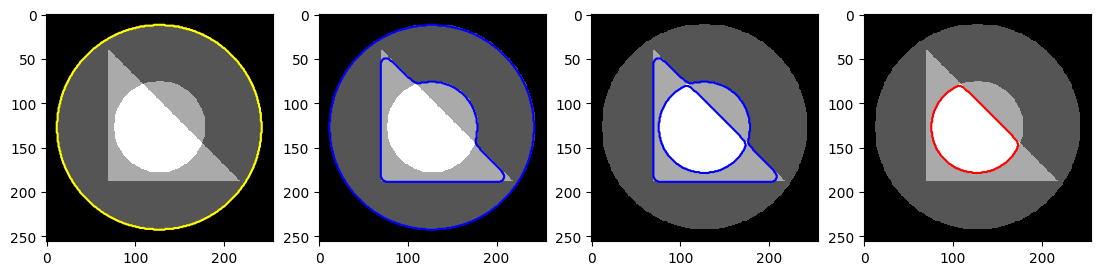

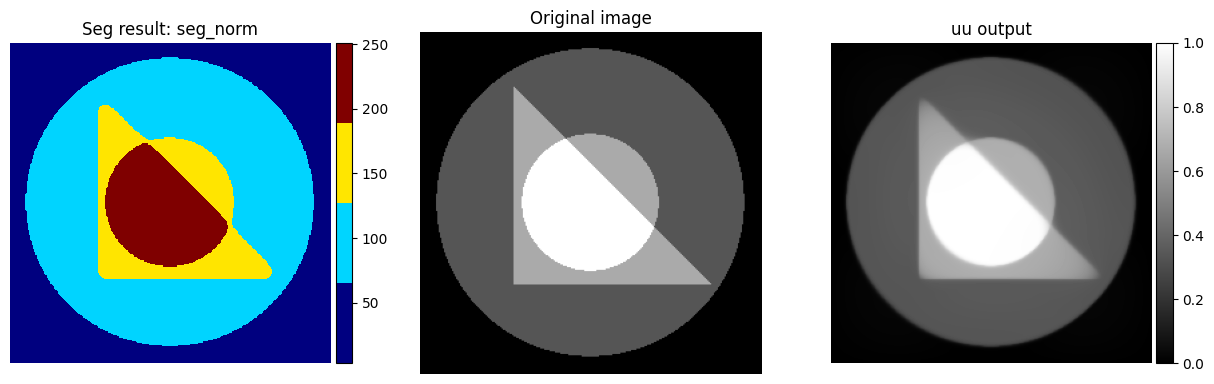

In [3]:
# TRY KMEANS IN CONTROLED INIT
Img_ori = io.imread('data/shape_multi_clean.png').astype('float64')
#Img_ori = io.imread('data/shape_multi_noise.png').astype('float64')
#Img_ori = io.imread('data/CTs1.tiff').astype('float64')
#Img_ori = io.imread('data/lung_axial1.png').astype('float64')
#Img_ori = io.imread('data/Cardiac_US_4ch.png').astype('float64')

if Img_ori.ndim==3:
    Img_ori = Img_ori[:,:,0]

Img = (Img_ori - Img_ori.min())/(Img_ori.max()-Img_ori.min())
# Set hyperparameter values
# Default: lbda=1, mu = 1, sigma = 2
lbda      = np.array([1]) 
mu        = 1 
sigma     = np.array([2])
k         = 4 # NEEDS TO BE 3 OR HIGHER
Nber_iter = 300

# Stage[1]: Get the smooth approximation uu
uu = CVMST_Seg(Img, lbda, mu, sigma, Nber_iter)
# Stage [2]: choose the (k-1) thresholds automatically using K-Means method
th,centers_vect_vals = ThdKmeans(uu, k)
print('Thresholds  from kmeans: th =',th)
print('Centers  from kmeans: centers_vect_vals =',centers_vect_vals)

# Showing segmentation result
Thresholds = th
seg_norm = SegResultShow(Img_ori, uu, Thresholds, k)

## From kmeans to Connected components

Vals_in_seg_norm =  [  3  86 168 251]
Smoothing seg_norm with max val =  251
Max value in labels of CCs =  3
Number of CCs =  4


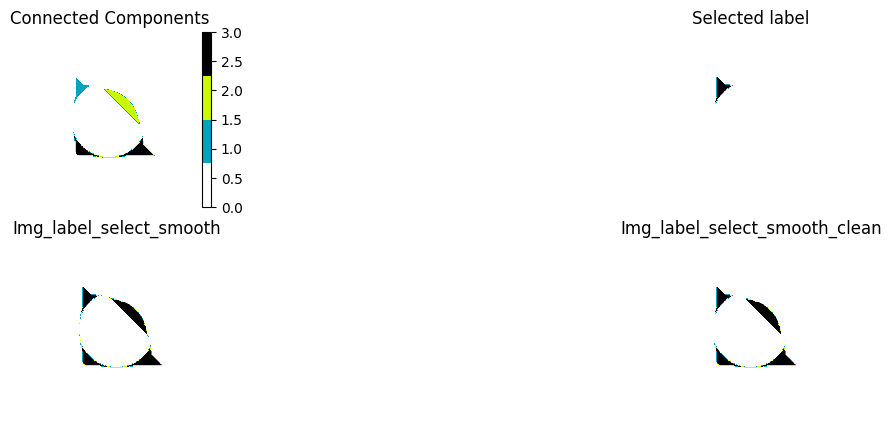

In [4]:
#Hyper-parameters:
# used as equality on seg_norm for selecting one phease
Label_to_select = k-2 
# used as equality on seg_norm CCs map for selecting one structure in the phase
CC_label_index = 1 

# Get vals in seg_norm
Vals_in_seg_norm = np.unique(seg_norm)
print('Vals_in_seg_norm = ',Vals_in_seg_norm)


# Select one phase 
Seg_norm_thresh = Vals_in_seg_norm[Label_to_select]; 


# Smoothing seg_norm
print('Smoothing seg_norm with max val = ', seg_norm.max())
Img_label_select_filter = gaussian(seg_norm, 2, preserve_range=True).astype(np.uint8)
Img_label_select_smooth = Img_label_select_filter == Seg_norm_thresh
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels of CCs = ',labels.max())
print('Number of CCs = ',numLabels)

# Extract 1 connected component
thresh = labels==CC_label_index

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(15, 5))
ax  = axes.ravel()
tmp = ax[0].imshow(labels, cmap=Colormap)
divider= make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
# ax[0]
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')
# ax[1]
ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
# ax[2]
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
# ax[3]
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');

# Practical Work: 
- Use any image provided in the /data/ folder. Some images are provided with ground-truth segmentations of structures of interest (gt)
- You can add images of your choice to segment that you need to include in the data folder if you want to propose some tests on this image in your report.
- Use "toy" images before real complex ones
- Make sure to distinuguish between the 2 steps of the variational segmentation method:
    1. Get uu = smooth approximation of the image to segment
    2. Use Kmeans to find "appropriate" thresholds on the approximation image (Which can be rerun several times commenting out the 1st step)
- You are also given with a post-processing step on extractin connected components and observe related issues, while you might think you are done with the segmentation task

    


## Hyperparameters of the method:
     - lbda: the weight for the data fidelity term 
     - mu: the weight for the smoothness constraint
     - sigma: the Split-Bregman optimisation weight parameter

## Questions:
### Question #1:
Run the segmentation method step #1 to answer (as many as possible of)  the following questions with concrete illustrations on toy images:
- If lbda is higher, then uu gets XX as seen in test image XX
- If mu is higher, then uu gets XX as seen in test image XX
- If sigma is higher, then XX

- Test if initialisation choice of uu is important

- Test with your own toy example the limits of robustness to noise level

### Question #2:
Segment real medical images. 
- Select one use case
- Justify you selection of hyperparameter values for step #1, based on your experiments on toy images.
- Optimise all step #2  hyperparameters:k, Smoothing, CC extraction, CC index selection
- If gt is available, propose a metric to compare the gt mask with your mask for the structure of interest


## My answers :
### Question #1:
 - If lbda is higher (mu and sigma unchanged), then uu gets closer to the original image, which reduces the robustness to noise level, as seen with shape_multi_noise.
    We can see that the noise is not removed from the final "smooth" image. Otherwise, it reduces the number of iterations required to complete the algorithm.
 - If mu is higher (lbda and sigma unchanged), then uu becomes blurry. The algorithm runs quicker, and the number of iterations slightly increases. It seems to be highly robust to noise, as seen with shape_multi_noise
 - If sigma is higher (lbda and mu unchanged), then the number of iterations is highly reduced (sigma = 50). The algorithm runs faster, without reducing the quality of uu, as seen with shape_multi_noise. If sigma is much higher (sigme = 1000), then the number of iterations keeps increasing. 
 In the algorithm, when we take a look at the calculations, the higher sigma is, the lower the gradient in uu is. This means that at high values of sigma, the image gets blurry. On the contrary, with low values of sigma (0.01), the image keeps its gradient, which means uu will keep the noise of the original image.

Then, if we try to increase both lambda and mu, we expect the gradient to be reduced by mu, but since lambda is elevated, we shall see the boundaries well defined, but the interior of the segmentation zones. As seen with CTs1 image, the details within the image disappeared, but we keep the information on the boundaries (even if it gets blurry).
I used lbda = 10, mu = 50  and sigma = 2

Using https://biomedpharmajournal.org/wp-content/uploads/2017/06/Vol10No2_Anal_Suga_fig2.jpg, we can test the robustness to noise.
 -> With the default hyperparameters, the uu output holds no information regarding the MRI, the segmentation zones is only well-defined on the edge of the skull.
 Thus we can try to smooth the image and keep it close the the original one by increasing both lambda and sigma. Increasing mu would smooth the image, but since it has a lot of noise it would even everything, which is why nothing can be observed with the default parameters. lbda = 10, mu = 1, sigma = 100 shows the original image with far less noise, but since the noise is removing details on the sides of the brain, the final uu doesn't hold much interests.

### Question #2:
 -> Using the MRI, to detect tumors inside the brain of a patient, we could see if the image shows anomalies inside the scanned brain, or if the patient's brain is healthy.
As explained before, those values were selected because it would have had the expected impact. If we try to change the values to get precisely the interior of the patient's brain, we can try to change values 1 by 1.
If we try lambda = 4, mu = 1, sigma = 2, we can see that the final uu image has almost no noise, but as the segmentation norm in color shows, there is no difference within the brain. We can then try to increase k to add more segmentation zones.
With k = 8, we can try to smooth the obtained segmentation zones by increasing sigma or mu. Since mu has a high impact, we put sigma to 20.
To even the segmentation zones, we can try to increase mu to 3.

The final image obtained, compared to the original, holds the details of the center of the brain, but fails to show the details of the sides.
We can still extract sufficient information from the final uu image, which is what would be needed in medical imagery.

Iterations: 0! Error: 0.35257080664329277
Iterations: 10! Error: 0.00139213975716172
Iterations: 20! Error: 0.00042045483926795777
Iterations: 30! Error: 0.0002415838861095564
Iterations: 40! Error: 0.00015097128889635477
Iterations: 50! Error: 9.819935249264584e-05
All iterations: 50
From plotting: uu.max()) =  1.0
Thresholds th = [0.11493579 0.25484595 0.367367   0.50159943 0.60672557 0.68605554
 0.77890515]
Img min and max= 0.0 255.0
Seg_norm min and max= 4 212


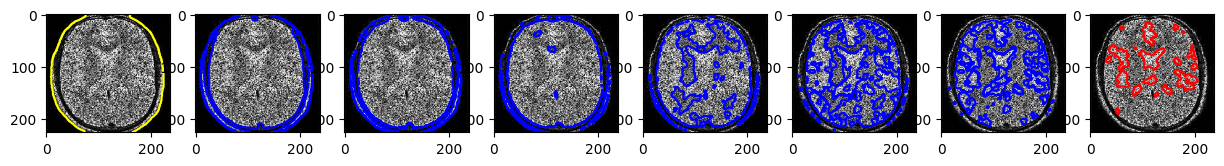

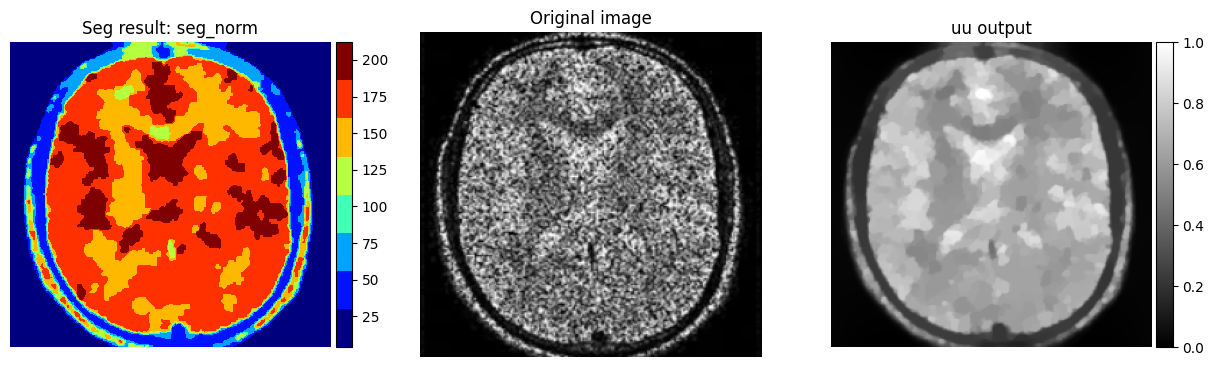

In [16]:
#Img_ori = io.imread('data/shape_multi_noise.png').astype('float64')
#Img_ori = io.imread('data/CTs1.tiff').astype('float64')
Img_ori = io.imread('data/MRI.png').astype('float64')

if Img_ori.ndim==3:
    Img_ori = Img_ori[:,:,0]
Img = (Img_ori - Img_ori.min())/(Img_ori.max()-Img_ori.min())

# Set hyperparameter values
# Default: lbda=1, mu = 1, sigma = 2
lbda      = np.array([4]) 
mu        = 3
sigma     = np.array([20])
k         = 8 # NEEDS TO BE 3 OR HIGHER
Nber_iter = 200

uu = CVMST_Seg(Img, lbda, mu, sigma, Nber_iter)
Thresholds,centers_vect_vals = ThdKmeans(uu, k)
seg_norm = SegResultShow(Img_ori, uu, Thresholds, k)